# Individuele opdracht Energy Transition
Lea van den Heuvel

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import dateparser
from datetime import timedelta
import pmdarima as pm
from statsmodels.graphics.gofplots import qqplot
import datetime

plt.rcParams["figure.figsize"] = (15,8)
plt.rcParams['image.cmap']='Paired'

## Data importeren
Als je de data download gaat het niet verder dan twee jaar terug, dus moeten we een eerder gedownloade dataset samenvoegen met een dataset van later.
### Eerste dataset

In [2]:
# Eerste dataset
ts1 = pd.read_csv('mijn-meterstanden.csv')
ts1.head(3)

Meetdatum  Stroom 1 (kWh)  Stroom 2 (kWh)  Teruglevering 1 (kWh)  \
0  25 mei 2021           9.172           8.999                  823.0   
1  24 mei 2021           9.166           8.999                  816.0   
2  23 mei 2021           9.153           8.999                  807.0   

   Teruglevering 2 (kWh)  Gas 1 (m3) Opmerkingen  
0                  2.009       6.931  Smartmeter  
1                  2.009       6.928  Smartmeter  
2                  2.009       6.927  Smartmeter

In [3]:
# Zet datum om
ts1['Meetdatum'] = ts1.Meetdatum.apply(lambda x: dateparser.parse(x))
ts1.head(3)

Meetdatum  Stroom 1 (kWh)  Stroom 2 (kWh)  Teruglevering 1 (kWh)  \
0 2021-05-25           9.172           8.999                  823.0   
1 2021-05-24           9.166           8.999                  816.0   
2 2021-05-23           9.153           8.999                  807.0   

   Teruglevering 2 (kWh)  Gas 1 (m3) Opmerkingen  
0                  2.009       6.931  Smartmeter  
1                  2.009       6.928  Smartmeter  
2                  2.009       6.927  Smartmeter

### Tweede dataset

In [4]:
# Tweede dataset
ts2 = pd.read_csv('mijn-meterstanden_3.csv')
ts2.head(3)

Meetdatum  Stroom 1 (kWh)  Stroom 2 (kWh)  Teruglevering 1 (kWh)  \
0  31 mei 2021           9.195           9.019                  865.0   
1  30 mei 2021           9.181           9.019                  843.0   
2  29 mei 2021           9.177           9.019                  823.0   

   Teruglevering 2 (kWh)  Gas 1 (m3) Opmerkingen  
0                  2.067       6.936  Smartmeter  
1                  2.067       6.935  Smartmeter  
2                  2.067       6.934  Smartmeter

In [5]:
# Zet datum om
ts2['Meetdatum'] = ts2.Meetdatum.apply(lambda x: dateparser.parse(x))
ts2.head(3)

Meetdatum  Stroom 1 (kWh)  Stroom 2 (kWh)  Teruglevering 1 (kWh)  \
0 2021-05-31           9.195           9.019                  865.0   
1 2021-05-30           9.181           9.019                  843.0   
2 2021-05-29           9.177           9.019                  823.0   

   Teruglevering 2 (kWh)  Gas 1 (m3) Opmerkingen  
0                  2.067       6.936  Smartmeter  
1                  2.067       6.935  Smartmeter  
2                  2.067       6.934  Smartmeter

In [6]:
# Voeg de twee datasets samen
ts = ts2[ts2.Meetdatum > ts1.Meetdatum.max()] # Set met data die extra worden toegevoegd aan ts1
ts = pd.concat([ts, ts1])
ts.head(10)

Meetdatum  Stroom 1 (kWh)  Stroom 2 (kWh)  Teruglevering 1 (kWh)  \
0 2021-05-31           9.195           9.019                  865.0   
1 2021-05-30           9.181           9.019                  843.0   
2 2021-05-29           9.177           9.019                  823.0   
3 2021-05-28           9.176           9.017                  823.0   
4 2021-05-27           9.175           9.014                  823.0   
5 2021-05-26           9.174           9.004                  823.0   
0 2021-05-25           9.172           8.999                  823.0   
1 2021-05-24           9.166           8.999                  816.0   
2 2021-05-23           9.153           8.999                  807.0   
3 2021-05-22           9.146           8.999                  799.0   

   Teruglevering 2 (kWh)  Gas 1 (m3) Opmerkingen  
0                  2.067       6.936  Smartmeter  
1                  2.067       6.935  Smartmeter  
2                  2.067       6.934  Smartmeter  
3                  2.042       6.934  Smartmeter  
4                  2.033       6.932  Smartmeter  
5                  2.022       6.931  Smartmeter  
0                  2.009       6.931  Smartmeter  
1                  2.009       6.928  Smartmeter  
2                  2.009       6.927  Smartmeter  
3                  2.009       6.925  Smartmeter

In [7]:
ts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 763 entries, 0 to 756
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Meetdatum              763 non-null    datetime64[ns]
 1   Stroom 1 (kWh)         763 non-null    float64       
 2   Stroom 2 (kWh)         763 non-null    float64       
 3   Teruglevering 1 (kWh)  342 non-null    float64       
 4   Teruglevering 2 (kWh)  344 non-null    float64       
 5   Gas 1 (m3)             763 non-null    float64       
 6   Opmerkingen            763 non-null    object        
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 47.7+ KB


In [8]:
#ts.set_index('Meetdatum', inplace = True)
#ts.head(3)

## Data inspecteren

In [9]:
ts.describe()

Stroom 1 (kWh)  Stroom 2 (kWh)  Teruglevering 1 (kWh)  \
count      763.000000      763.000000             342.000000   
mean         9.460940        9.288339             437.938596   
std         37.808527       38.176156             183.484581   
min          0.000000        0.000000               0.000000   
25%          6.484000        6.328500             364.000000   
50%          7.715000        7.552000             452.000000   
75%          8.403000        8.200500             525.250000   
max        915.000000      935.000000             865.000000   

       Teruglevering 2 (kWh)  Gas 1 (m3)  
count             344.000000  763.000000  
mean              141.698762    6.000912  
std               281.505174   17.620136  
min                 0.000000    0.000000  
25%                 1.189750    4.385500  
50%                 1.386000    5.488000  
75%                53.250000    5.761500  
max               997.000000  489.000000

In [10]:
# Missende waarden
ts.isna().sum()

Meetdatum                  0
Stroom 1 (kWh)             0
Stroom 2 (kWh)             0
Teruglevering 1 (kWh)    421
Teruglevering 2 (kWh)    419
Gas 1 (m3)                 0
Opmerkingen                0
dtype: int64

In [11]:
ts[ts['Teruglevering 1 (kWh)'].isnull()]
# Er zijn missende waarden omdat er toen nog geen zonnepanelen (=teruglevering) was

Meetdatum  Stroom 1 (kWh)  Stroom 2 (kWh)  Teruglevering 1 (kWh)  \
332 2020-06-27           7.915           7.751                    NaN   
333 2020-06-26           7.914           7.750                    NaN   
334 2020-06-25           7.913           7.748                    NaN   
335 2020-06-24           7.911           7.733                    NaN   
336 2020-06-23           7.909           7.729                    NaN   
..         ...             ...             ...                    ...   
751 2017-03-01         915.000         935.000                    NaN   
752 2017-01-01         518.000         504.000                    NaN   
753 2016-11-01          79.000          54.000                    NaN   
755 2016-10-20          36.876          45.234                    NaN   
756 2016-09-13          36.635          44.990                    NaN   

     Teruglevering 2 (kWh)  Gas 1 (m3)     Opmerkingen  
332                   41.0       5.508      Smartmeter  
333                   16.0       5.508      Smartmeter  
334                    NaN       5.507      Smartmeter  
335                    NaN       5.507      Smartmeter  
336                    NaN       5.507      Smartmeter  
..                     ...         ...             ...  
751                    NaN       1.020      Smartmeter  
752                    NaN     489.000      Smartmeter  
753                    NaN      47.000      Smartmeter  
755                    NaN      21.304    Uitbouwstand  
756                    NaN      21.240  Jaarafrekening  

[421 rows x 7 columns]

In [12]:
# Duplicates bekijken
ts[ts.duplicated()]

Empty DataFrame
Columns: [Meetdatum, Stroom 1 (kWh), Stroom 2 (kWh), Teruglevering 1 (kWh), Teruglevering 2 (kWh), Gas 1 (m3), Opmerkingen]
Index: []

In [13]:
# Functie om te checken of datum vóór en na in ts staan, zodat het gefilterd kan worden en het een timeseries is
def check_dates(x):
    d = timedelta(days=1)
    # Check of dag ervoor en dag erna in ts staan
    if ((x-d) in ts.Meetdatum.values) and ((x+d) in ts.Meetdatum.values):
        return True
    else: return False

In [14]:
# Nieuwe kolom met of de datum ervoor en erna in ts staan
ts['check_dates'] = ts['Meetdatum'].apply(lambda x: check_dates(x))
ts.head(3)

Meetdatum  Stroom 1 (kWh)  Stroom 2 (kWh)  Teruglevering 1 (kWh)  \
0 2021-05-31           9.195           9.019                  865.0   
1 2021-05-30           9.181           9.019                  843.0   
2 2021-05-29           9.177           9.019                  823.0   

   Teruglevering 2 (kWh)  Gas 1 (m3) Opmerkingen  check_dates  
0                  2.067       6.936  Smartmeter        False  
1                  2.067       6.935  Smartmeter         True  
2                  2.067       6.934  Smartmeter         True

In [15]:
# Filter ts zodat het time series is
ts = ts[ts['check_dates']]
ts.head(3)

Meetdatum  Stroom 1 (kWh)  Stroom 2 (kWh)  Teruglevering 1 (kWh)  \
1 2021-05-30           9.181           9.019                  843.0   
2 2021-05-29           9.177           9.019                  823.0   
3 2021-05-28           9.176           9.017                  823.0   

   Teruglevering 2 (kWh)  Gas 1 (m3) Opmerkingen  check_dates  
1                  2.067       6.935  Smartmeter         True  
2                  2.067       6.934  Smartmeter         True  
3                  2.042       6.934  Smartmeter         True

In [16]:
ts.drop(columns = ['Opmerkingen', 'check_dates'], inplace = True) # Drop onnodige kolommen
ts.set_index('Meetdatum', inplace =True) # Set index
ts.head(3)

Stroom 1 (kWh)  Stroom 2 (kWh)  Teruglevering 1 (kWh)  \
Meetdatum                                                           
2021-05-30           9.181           9.019                  843.0   
2021-05-29           9.177           9.019                  823.0   
2021-05-28           9.176           9.017                  823.0   

            Teruglevering 2 (kWh)  Gas 1 (m3)  
Meetdatum                                      
2021-05-30                  2.067       6.935  
2021-05-29                  2.067       6.934  
2021-05-28                  2.042       6.934

In [17]:
ts.columns

Index(['Stroom 1 (kWh)', 'Stroom 2 (kWh)', 'Teruglevering 1 (kWh)',
       'Teruglevering 2 (kWh)', 'Gas 1 (m3)'],
      dtype='object')

In [18]:
# Het zijn geen floats maar integers, dus alle getallen boven de 1000 moeten worden vermenigvuldigd met 1000
cols = [ 'Stroom 1 (kWh)', 'Stroom 2 (kWh)', 'Teruglevering 1 (kWh)', 'Teruglevering 2 (kWh)', 'Gas 1 (m3)']

for col in cols:
    ts[col] = ts[col].apply(lambda x: (x*1000) if (x < 10) else x)
    
ts.head(3)

Stroom 1 (kWh)  Stroom 2 (kWh)  Teruglevering 1 (kWh)  \
Meetdatum                                                           
2021-05-30          9181.0          9019.0                  843.0   
2021-05-29          9177.0          9019.0                  823.0   
2021-05-28          9176.0          9017.0                  823.0   

            Teruglevering 2 (kWh)  Gas 1 (m3)  
Meetdatum                                      
2021-05-30                 2067.0      6935.0  
2021-05-29                 2067.0      6934.0  
2021-05-28                 2042.0      6934.0

### Nieuwe kolommen

In [19]:
# Stroom in kWh
ts['stroom'] = ts['Stroom 1 (kWh)'] + ts['Stroom 2 (kWh)']
# Teruglevering in kWh
ts['teruglevering'] = ts['Teruglevering 1 (kWh)'] + ts['Teruglevering 2 (kWh)']
# Gas in m3
ts.rename(columns = {'Gas 1 (m3)': 'gas'}, inplace = True)
ts.head(3)

Stroom 1 (kWh)  Stroom 2 (kWh)  Teruglevering 1 (kWh)  \
Meetdatum                                                           
2021-05-30          9181.0          9019.0                  843.0   
2021-05-29          9177.0          9019.0                  823.0   
2021-05-28          9176.0          9017.0                  823.0   

            Teruglevering 2 (kWh)     gas   stroom  teruglevering  
Meetdatum                                                          
2021-05-30                 2067.0  6935.0  18200.0         2910.0  
2021-05-29                 2067.0  6934.0  18196.0         2890.0  
2021-05-28                 2042.0  6934.0  18193.0         2865.0

## Visualisaties
### Verloop over de tijd

In [20]:
ts.columns

Index(['Stroom 1 (kWh)', 'Stroom 2 (kWh)', 'Teruglevering 1 (kWh)',
       'Teruglevering 2 (kWh)', 'gas', 'stroom', 'teruglevering'],
      dtype='object')

In [21]:
# Kolommen die gevisualiseerd moeten worden
cols = ['gas', 'stroom', 'teruglevering']

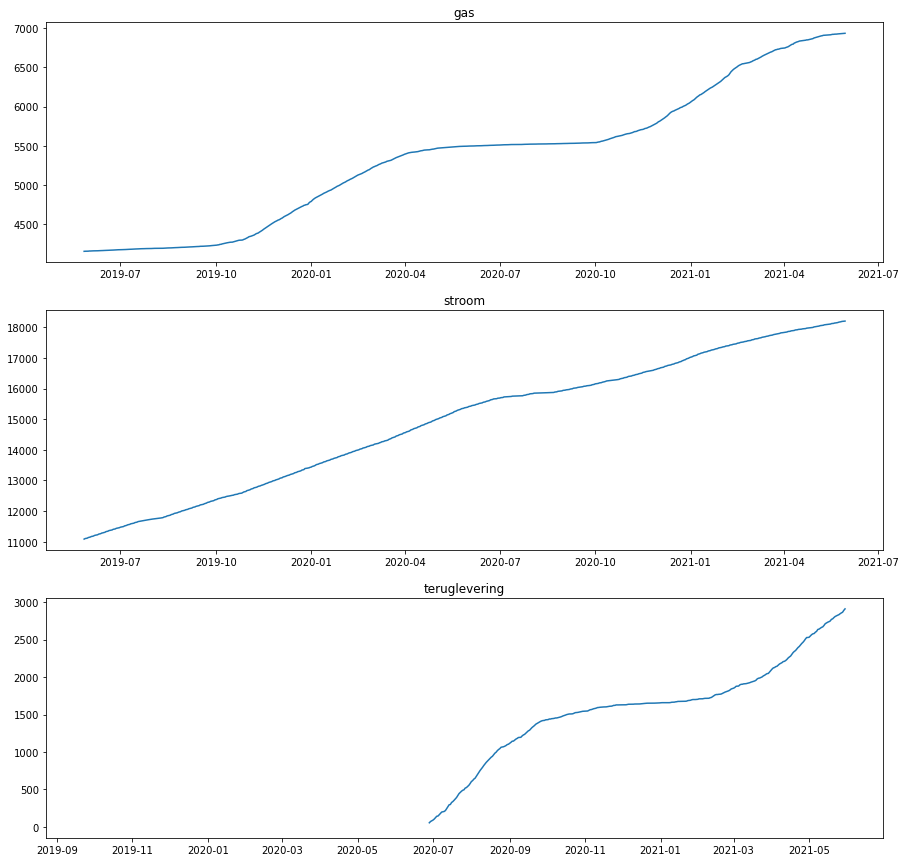

In [22]:
fig, ax = plt.subplots(3,1, figsize = (15,15))

for col in cols:
    i = cols.index(col)
    ax[i].plot(ts[col])
    ax[i].set_title(col)
    
plt.show()

In [23]:
# Meter is cumulatief dus differentieren om gebruik per dag te krijgen
# Absolute waardes pakken
ts = np.abs(ts[cols].diff())
ts.head()

gas  stroom  teruglevering
Meetdatum                             
2021-05-30  NaN     NaN            NaN
2021-05-29  1.0     4.0           20.0
2021-05-28  0.0     3.0           25.0
2021-05-27  2.0     4.0            9.0
2021-05-26  1.0    11.0           11.0

<Figure size 1080x576 with 0 Axes>

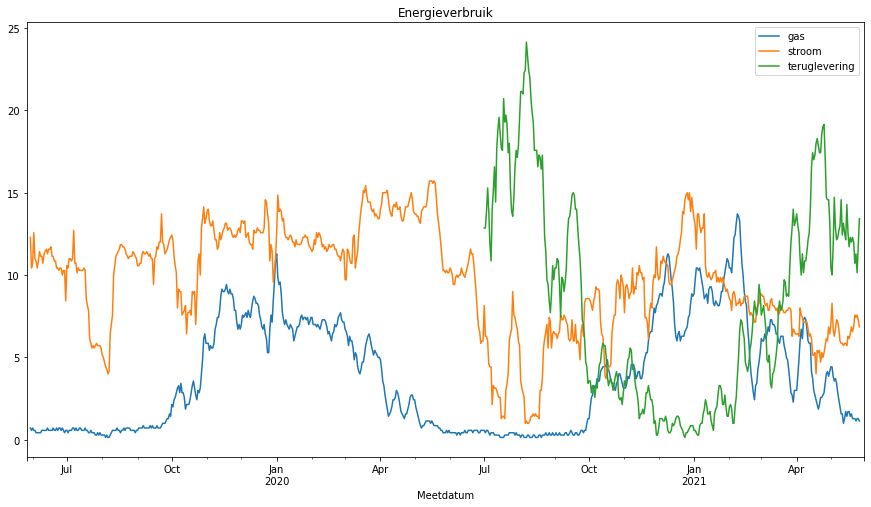

In [24]:
plt.set_cmap('Paired')

ts_mean_gas = ts[['gas', 'stroom', 'teruglevering']].rolling(window = 7, center = True).mean()
ts_mean_gas.plot()#color = "tab:pink")
plt.title('Energieverbruik')
plt.legend()
plt.show()

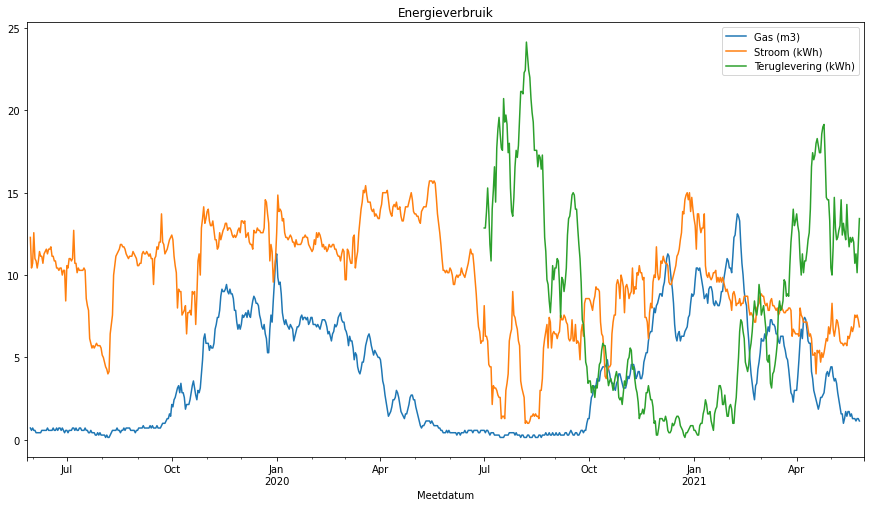

In [25]:
# Alles in één plot
plt.set_cmap('Paired')

ts_mean_gas = ts['gas'].rolling(window = 7, center = True).mean()
ts_mean_gas.plot(label = "Gas (m3)")#, color = "tab:pink")

ts_mean_stroom = ts['stroom'].rolling(window = 7, center = True).mean()
ts_mean_stroom.plot(label = "Stroom (kWh)")#, color = "orange")

ts_mean_terug = ts['teruglevering'].dropna().rolling(window = 7, center = True).mean()
ts_mean_terug.plot(label = "Teruglevering (kWh)")#, color = "green")

plt.title('Energieverbruik')
plt.legend()
plt.show()

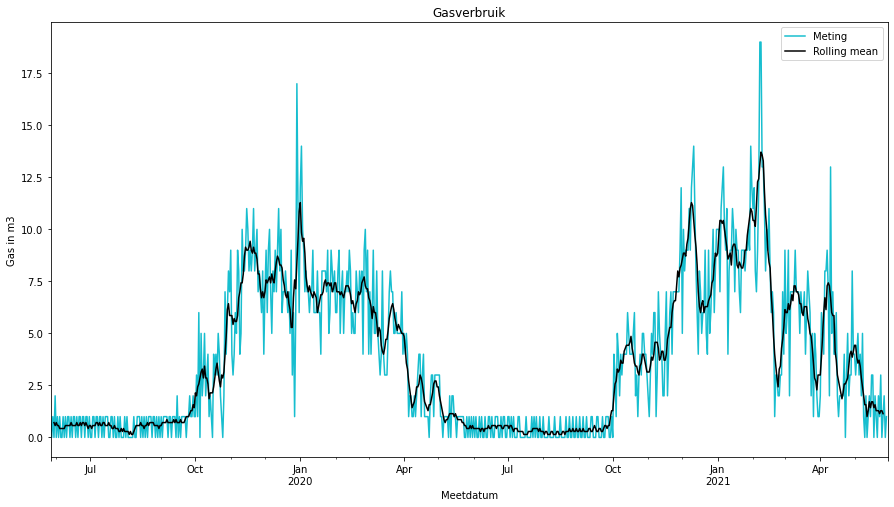

In [26]:
ts['gas'].plot(color = 'tab:cyan', label = 'Meting')

ts_mean = ts['gas'].rolling(window = 7, center = True).mean()
ts_mean.plot(color = "k", label = "Rolling mean")

plt.title('Gasverbruik')
plt.ylabel('Gas in m3')
plt.legend()
plt.show()

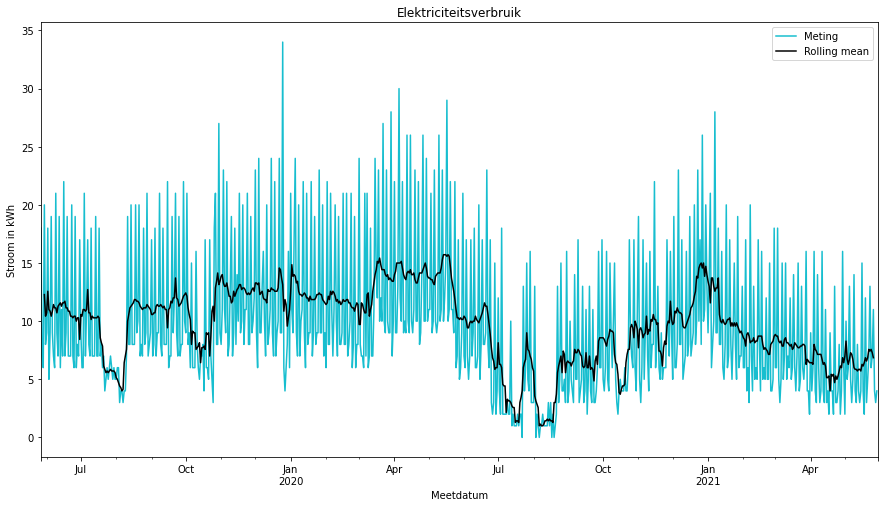

In [27]:
ts['stroom'].plot(color = 'tab:cyan', label = 'Meting')

ts_mean = ts['stroom'].rolling(window = 7, center = True).mean()
ts_mean.plot(color = "k", label = "Rolling mean")

plt.title('Elektriciteitsverbruik')
plt.ylabel('Stroom in kWh')
plt.legend()
plt.show()

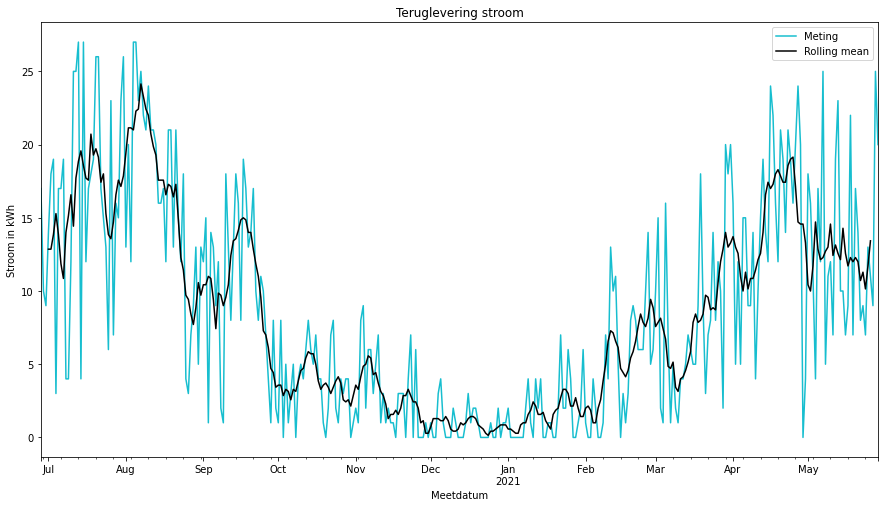

In [28]:
ts['teruglevering'].dropna().plot(color = 'tab:cyan', label = 'Meting')

ts_mean = ts['teruglevering'].dropna().rolling(window = 7, center = True).mean()
ts_mean.plot(color = "k", label = "Rolling mean")

plt.title('Teruglevering stroom')
plt.ylabel('Stroom in kWh')
plt.legend()
plt.show()

### Verdeling van de data

In [29]:
# Functie om seizoen te bepalen
def season(x):
    if x == 12 or x <= 2:
        return "Winter"
    elif x >= 8:
        return "Autumn"
    elif x >= 6:
        return "Summer"
    else: return "Spring"

In [30]:
# Nieuwe var voor seizoen
ts['month'] = ts.index.month # kolom met maand
ts['month_name'] = ts.index.month_name() # kolom met maand
ts['season'] = ts['month'].apply(lambda x: season(x)) # kolom met seizoen
ts['season'] = ts['season'].astype('category')
ts.head(3)

gas  stroom  teruglevering  month month_name  season
Meetdatum                                                       
2021-05-30  NaN     NaN            NaN      5        May  Spring
2021-05-29  1.0     4.0           20.0      5        May  Spring
2021-05-28  0.0     3.0           25.0      5        May  Spring

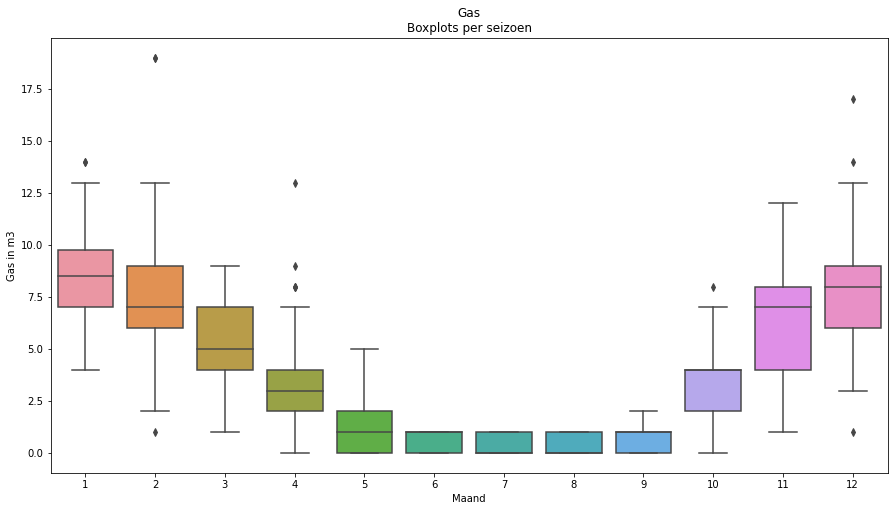

In [31]:
sns.boxplot(data = ts, y = 'gas', x = 'month')
plt.title('Gas\nBoxplots per seizoen')
plt.xlabel('Maand')
plt.ylabel('Gas in m3')
plt.show()

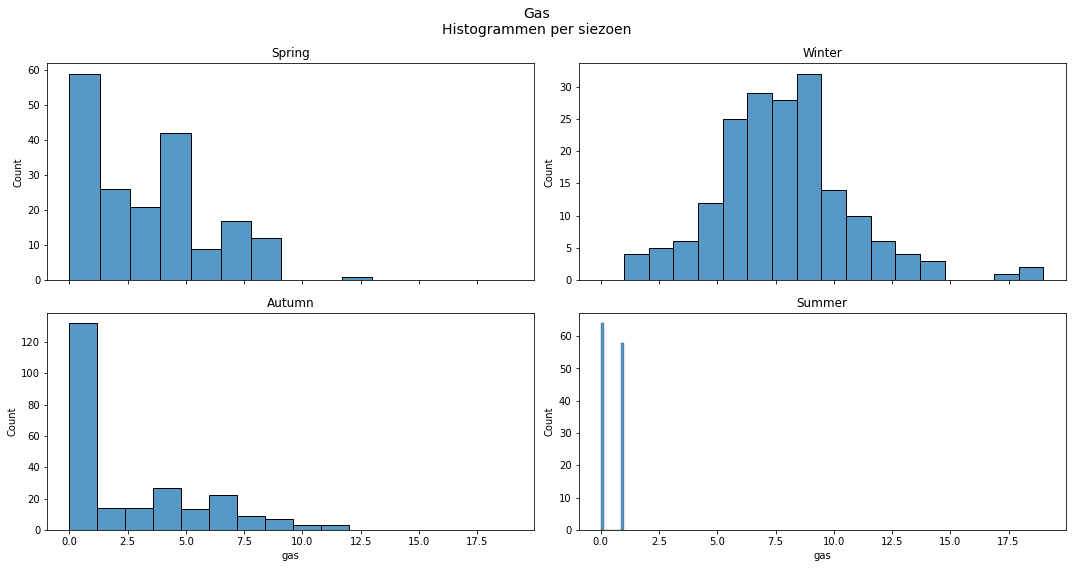

In [32]:
fig, ax = plt.subplots(2,2, sharex = True)
dict_plots = {ax[0][0]: ts.season.unique()[0], # Dict met plot en bijbehorende seizoen
              ax[0][1]: ts.season.unique()[1],
              ax[1][0]: ts.season.unique()[2],
              ax[1][1]: ts.season.unique()[3]}

for i in dict_plots:
    sns.histplot(data = ts[ts['season']==dict_plots[i]], 
                 x = 'gas',
                 ax = i)
    i.set_title(dict_plots[i])

plt.suptitle('Gas\nHistogrammen per siezoen', size = 14)
plt.tight_layout()
plt.show()

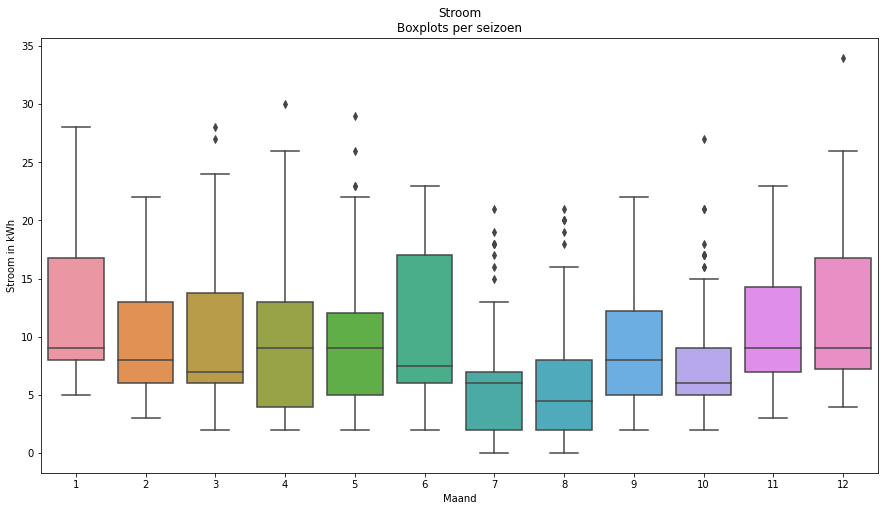

In [33]:
sns.boxplot(data = ts, y = 'stroom', x = 'month')
plt.title('Stroom\nBoxplots per seizoen')
plt.xlabel('Maand')
plt.ylabel('Stroom in kWh')
plt.show()

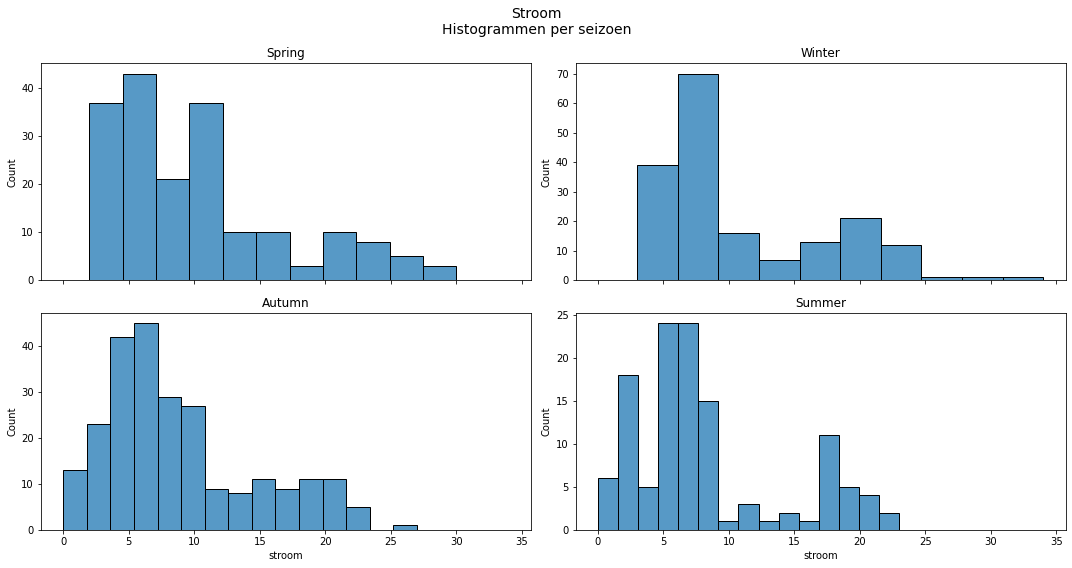

In [34]:
fig, ax = plt.subplots(2,2, sharex = True)
dict_plots = {ax[0][0]: ts.season.unique()[0], # Dict met plot en bijbehorende seizoen
              ax[0][1]: ts.season.unique()[1],
              ax[1][0]: ts.season.unique()[2],
              ax[1][1]: ts.season.unique()[3]}

for i in dict_plots:
    sns.histplot(data = ts[ts['season']==dict_plots[i]], 
                 x = 'stroom',
                 ax = i)
    i.set_title(dict_plots[i])

plt.suptitle('Stroom\nHistogrammen per seizoen', size = 14)
plt.tight_layout()
plt.show()

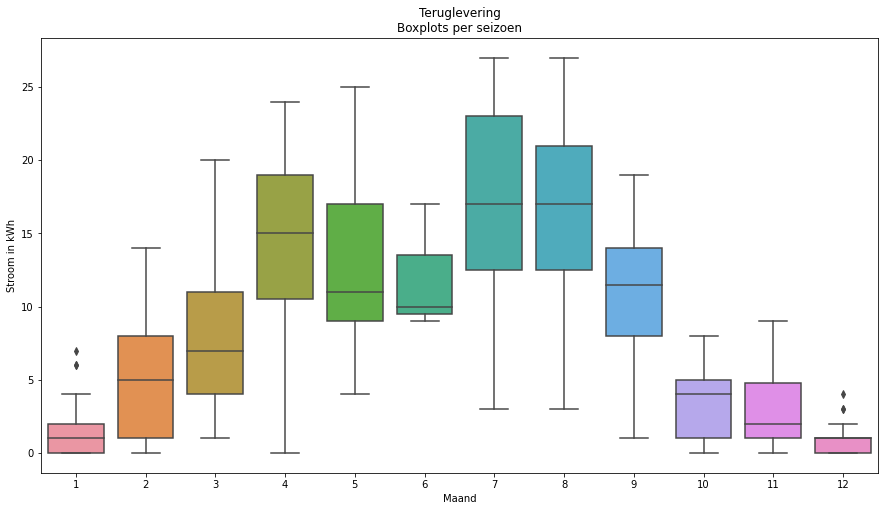

In [35]:
sns.boxplot(data = ts, y = 'teruglevering', x = 'month')
plt.title('Teruglevering\nBoxplots per seizoen')
plt.xlabel('Maand')
plt.ylabel('Stroom in kWh')
plt.show()

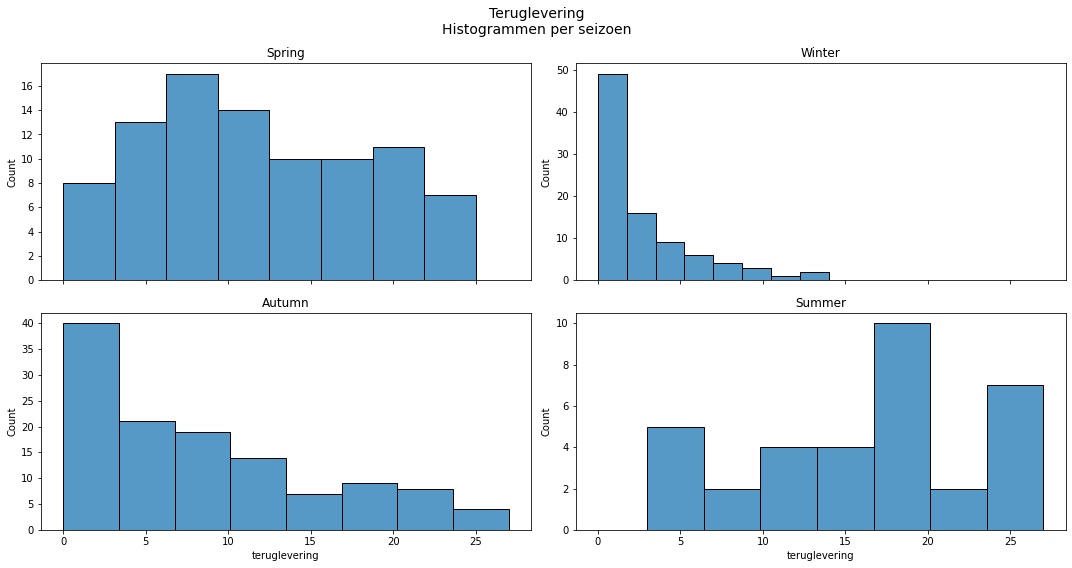

In [36]:
fig, ax = plt.subplots(2,2, sharex = True)
dict_plots = {ax[0][0]: ts.season.unique()[0], # Dict met plot en bijbehorende seizoen
              ax[0][1]: ts.season.unique()[1],
              ax[1][0]: ts.season.unique()[2],
              ax[1][1]: ts.season.unique()[3]}

for i in dict_plots:
    sns.histplot(data = ts[ts['season']==dict_plots[i]], 
                 x = 'teruglevering',
                 ax = i)
    i.set_title(dict_plots[i])

plt.suptitle('Teruglevering\nHistogrammen per seizoen', size = 14)
plt.tight_layout()
plt.show()

### Gemiddelden

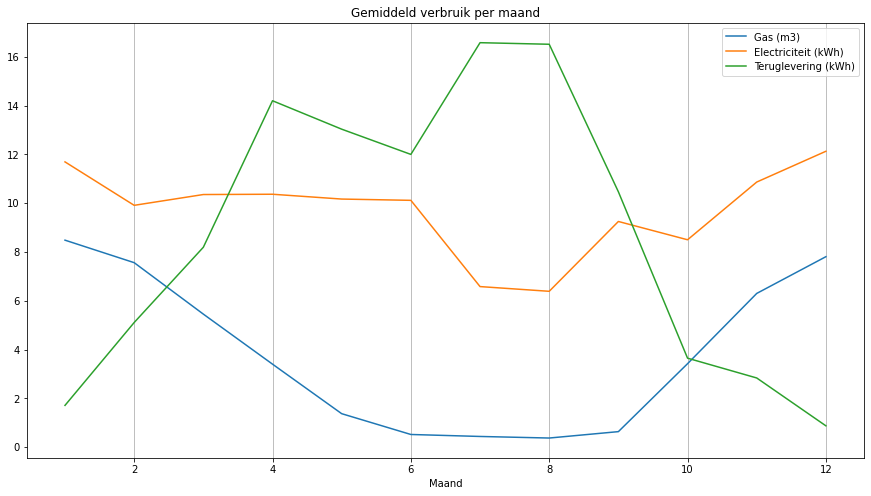

In [37]:
ts_grouped_gas = ts.groupby('month')['gas'].mean()
ts_grouped_gas.plot(label = 'Gas (m3)')

ts_grouped_stroom = ts.groupby('month')['stroom'].mean()
ts_grouped_stroom.plot(label = 'Electriciteit (kWh)')

ts_grouped_terug = ts.groupby('month')['teruglevering'].mean()
ts_grouped_terug.plot(label = 'Teruglevering (kWh)')

plt.title('Gemiddeld verbruik per maand')
plt.xlabel('Maand')
plt.grid(axis = 'x')
plt.legend()
plt.show()

### Correlatie

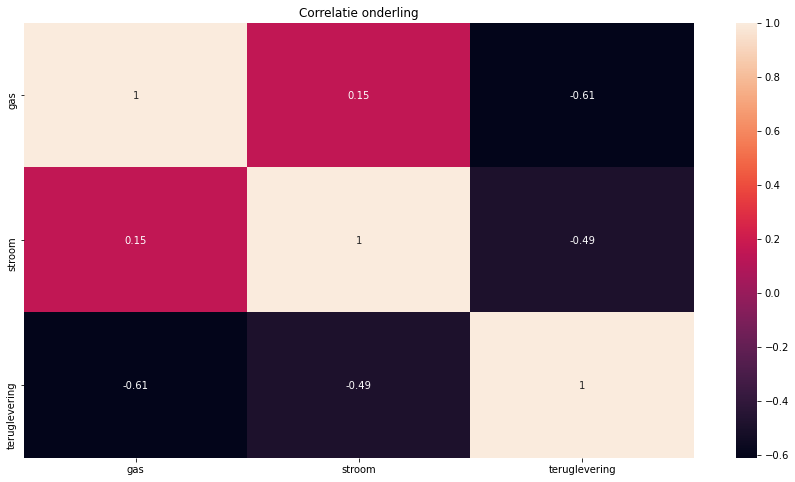

In [38]:
cor_matrix = ts[cols].corr()
sns.heatmap(cor_matrix, annot=True)
plt.title('Correlatie onderling')
plt.show()

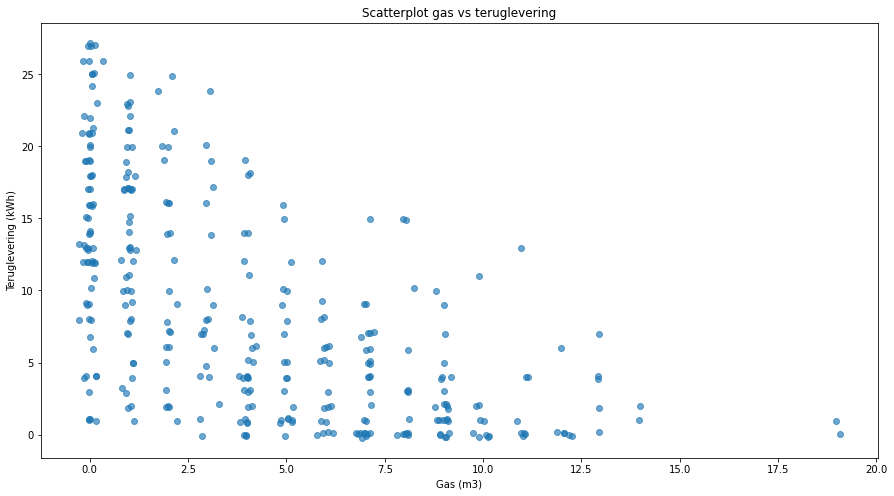

In [39]:
plt.scatter(x = ts['gas'] + np.random.normal(0,0.1,len(ts)), 
            y = ts['teruglevering'] + np.random.normal(0,0.1,len(ts)),
            alpha = 0.65)
plt.title('Scatterplot gas vs teruglevering')
plt.xlabel('Gas (m3)')
plt.ylabel('Teruglevering (kWh)')
plt.show()

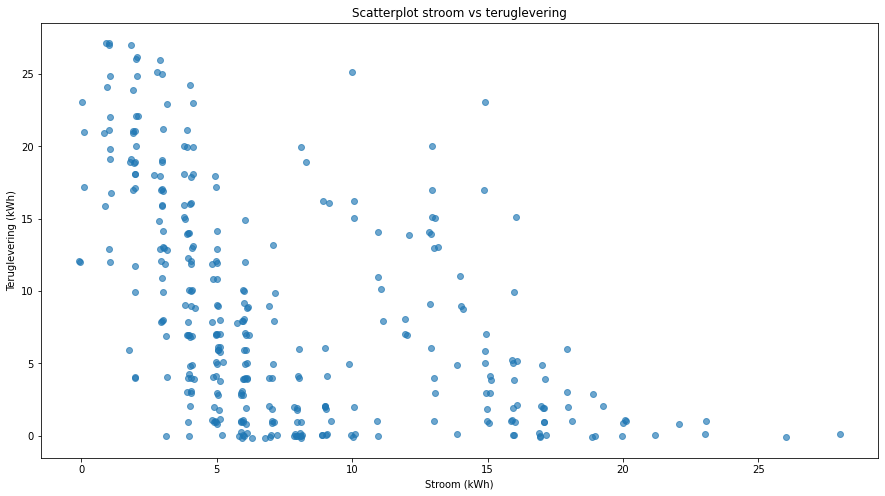

In [40]:
plt.scatter(x = ts['stroom'] + np.random.normal(0,0.1,len(ts)), 
            y = ts['teruglevering'] + np.random.normal(0,0.1,len(ts)),
            alpha = 0.65)
plt.title('Scatterplot stroom vs teruglevering')
plt.xlabel('Stroom (kWh)')
plt.ylabel('Teruglevering (kWh)')
plt.show()

### Trend en seizoen

In [41]:
ts.head(3)

gas  stroom  teruglevering  month month_name  season
Meetdatum                                                       
2021-05-30  NaN     NaN            NaN      5        May  Spring
2021-05-29  1.0     4.0           20.0      5        May  Spring
2021-05-28  0.0     3.0           25.0      5        May  Spring

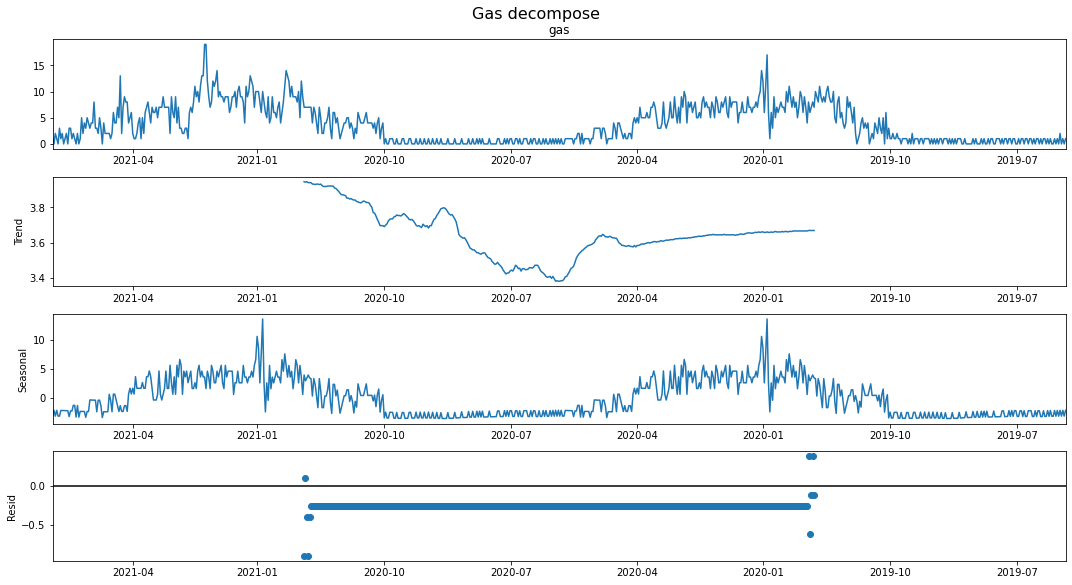

In [42]:
decomp = sm.tsa.seasonal_decompose(ts['gas'].dropna(), 
                                   period = 365)
decomp.plot()
plt.suptitle('Gas decompose', y = 1.01, size = 16)
plt.show()

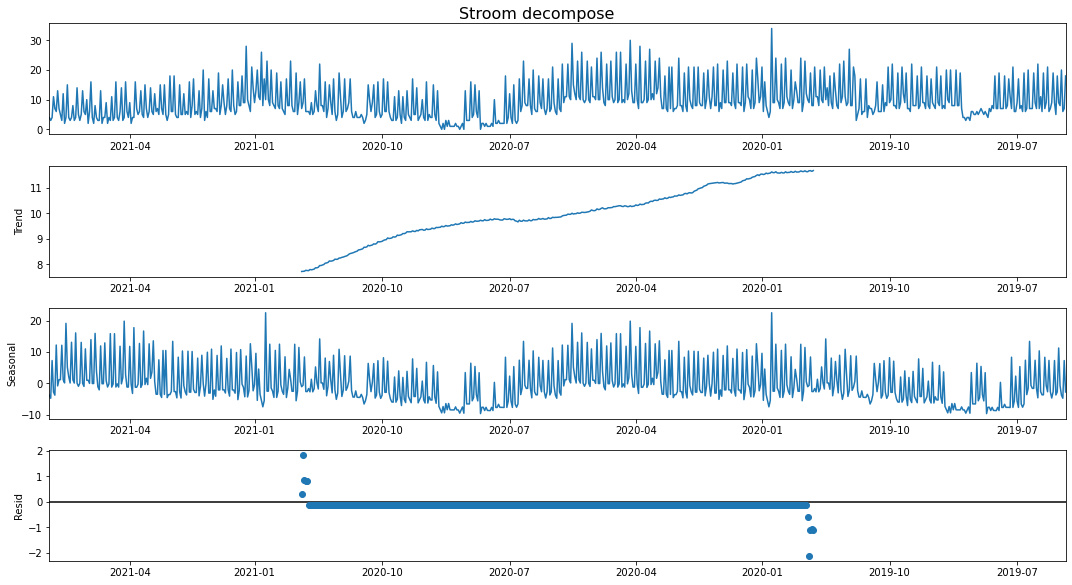

In [43]:
decomp = sm.tsa.seasonal_decompose(ts[['stroom']].dropna(), 
                                   period = 365)
decomp.plot()
plt.suptitle('Stroom decompose', y = 1.01, size = 16)
plt.show()

## ARIMA model
### Stationarity

In [44]:
ts['log'] = np.log(ts['gas'])
ts['sqrt'] = np.sqrt(ts['gas'])
ts

C:\Users\Gebruiker\anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


gas  stroom  teruglevering  month month_name  season       log  \
Meetdatum                                                                    
2021-05-30  NaN     NaN            NaN      5        May  Spring       NaN   
2021-05-29  1.0     4.0           20.0      5        May  Spring  0.000000   
2021-05-28  0.0     3.0           25.0      5        May  Spring      -inf   
2021-05-27  2.0     4.0            9.0      5        May  Spring  0.693147   
2021-05-26  1.0    11.0           11.0      5        May  Spring  0.000000   
...         ...     ...            ...    ...        ...     ...       ...   
2019-05-31  2.0     8.0            NaN      5        May  Spring  0.693147   
2019-05-30  0.0    20.0            NaN      5        May  Spring      -inf   
2019-05-29  1.0     6.0            NaN      5        May  Spring  0.000000   
2019-05-28  0.0     7.0            NaN      5        May  Spring      -inf   
2019-05-27  1.0    18.0            NaN      5        May  Spring  0.000000   

                sqrt  
Meetdatum             
2021-05-30       NaN  
2021-05-29  1.000000  
2021-05-28  0.000000  
2021-05-27  1.414214  
2021-05-26  1.000000  
...              ...  
2019-05-31  1.414214  
2019-05-30  0.000000  
2019-05-29  1.000000  
2019-05-28  0.000000  
2019-05-27  1.000000  

[735 rows x 8 columns]

In [45]:
# Test voor gas
res_adf = adfuller(ts['sqrt'].diff().dropna())
print(f'T: {res_adf[0]}')
print(f'p-value: {res_adf[1]}')

T: -13.906143647234451
p-value: 5.618370712343049e-26


In [46]:
ts_diff = ts[['gas', 'sqrt']].diff().dropna()
ts_diff.head(3)

gas      sqrt
Meetdatum                
2021-05-28 -1.0 -1.000000
2021-05-27  2.0  1.414214
2021-05-26 -1.0 -0.414214

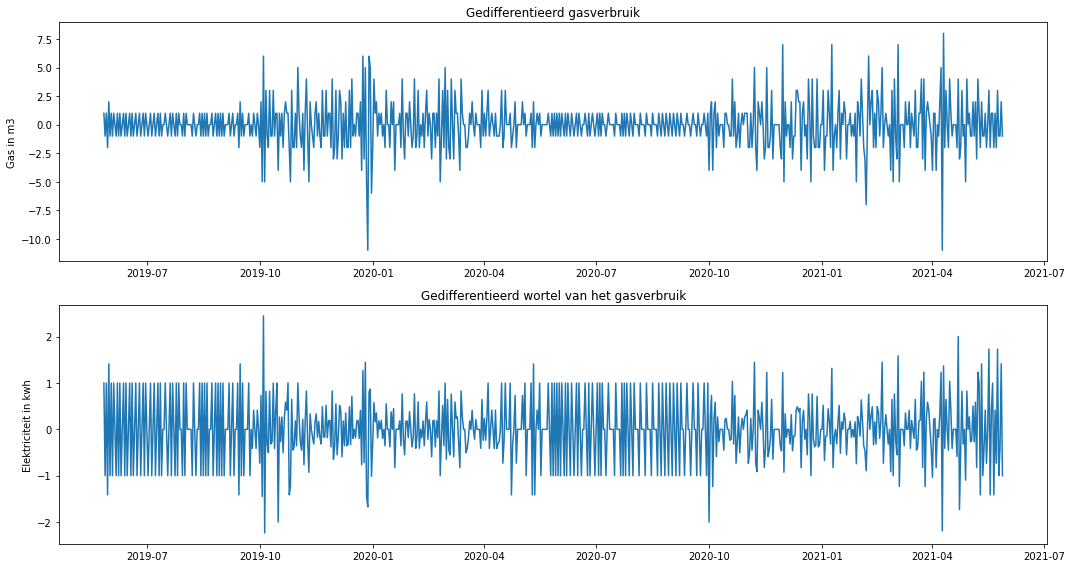

In [47]:
fig, ax = plt.subplots(2, 1)

ax[0].plot(ts_diff['gas'])
ax[0].set_title('Gedifferentieerd gasverbruik')
ax[0].set_ylabel('Gas in m3')

ax[1].plot(ts_diff['sqrt'])
ax[1].set_title('Gedifferentieerd wortel van het gasverbruik')
ax[1].set_ylabel('Elektriciteit in kwh')

plt.tight_layout()
plt.show()

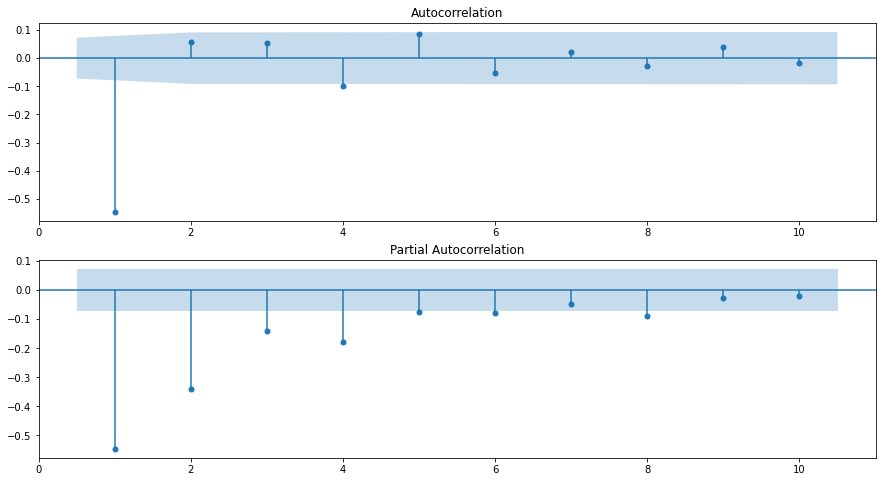

In [48]:
# ACF en PACF voor gas
fig, ax = plt.subplots(2,1)

plot_acf(ts_diff['sqrt'], lags = 10, zero = False, ax = ax[0])
plot_pacf(ts_diff['sqrt'], lags = 10, zero = False, ax = ax[1])
plt.show()

### Test-train split

In [49]:
ts_train = ts.loc['2021-02':]
ts_test = ts.loc[:'2021-03']
ts_train.head()

gas  stroom  teruglevering  month month_name  season       log  \
Meetdatum                                                                    
2021-02-28  4.0    18.0            6.0      2   February  Winter  1.386294   
2021-02-27  7.0     5.0            5.0      2   February  Winter  1.945910   
2021-02-26  3.0     4.0           14.0      2   February  Winter  1.098612   
2021-02-25  3.0     4.0           10.0      2   February  Winter  1.098612   
2021-02-24  2.0    15.0            6.0      2   February  Winter  0.693147   

                sqrt  
Meetdatum             
2021-02-28  2.000000  
2021-02-27  2.645751  
2021-02-26  1.732051  
2021-02-25  1.732051  
2021-02-24  1.414214

In [50]:
ts_test.tail()

gas  stroom  teruglevering  month month_name  season       log  \
Meetdatum                                                                    
2021-03-05  2.0     3.0           16.0      3      March  Spring  0.693147   
2021-03-04  9.0     5.0            1.0      3      March  Spring  2.197225   
2021-03-03  6.0    18.0            2.0      3      March  Spring  1.791759   
2021-03-02  5.0     6.0           15.0      3      March  Spring  1.609438   
2021-03-01  9.0     6.0           10.0      3      March  Spring  2.197225   

                sqrt  
Meetdatum             
2021-03-05  1.414214  
2021-03-04  3.000000  
2021-03-03  2.449490  
2021-03-02  2.236068  
2021-03-01  3.000000

### Vanaf hieronder alleen gas
#### Model zonder seizoen

In [51]:
res_aa = pm.auto_arima(ts_train['sqrt'], 
                      d = 1,
                      start_p = 0, max_p = 2,
                      start_q = 1, max_q = 4,
                      #seasonal = True, m = 365, D = 1,
                      #start_P = 1, max_P = 2,
                      #start_Q = 1, max_Q = 2,
                      information_criterion = 'aic', trace = True, 
                      error_action = 'ignore', stepwise = True
                      )

Performing stepwise search to minimize aic
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=977.826, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1322.381, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1100.499, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1320.384, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=975.218, Time=0.51 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=977.014, Time=0.63 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=977.121, Time=0.78 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=975.507, Time=0.65 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1029.483, Time=0.23 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=974.409, Time=1.37 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=975.369, Time=2.48 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=975.312, Time=1.19 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=972.607, Time=0.73 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=975.336, Time=0.44 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=9

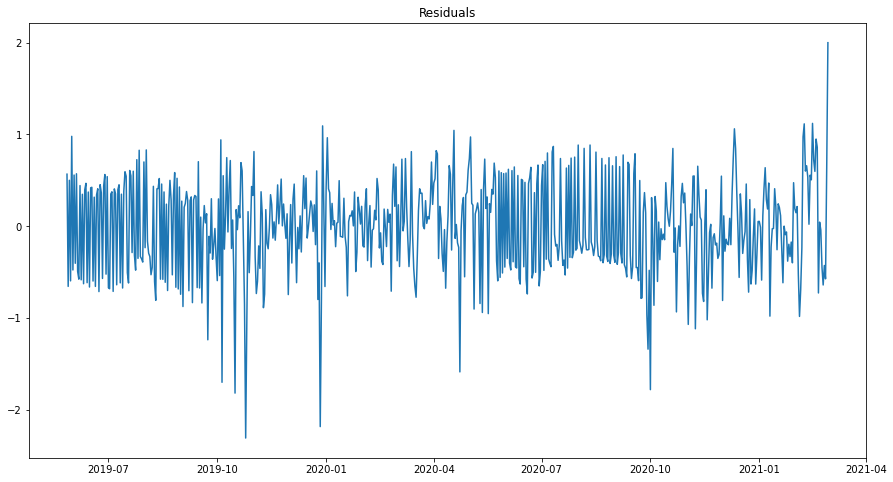

In [52]:
# Bekijk residuals
fig, ax = plt.subplots()
ax.plot(ts_train.index, res_aa.resid())
#result_a_fourier.resid().plot()
plt.title('Residuals')
plt.show()

In [53]:
# Maak pred voor testset
pred_gas_arima1 = res_aa.predict(len(ts_test)) ** 2
pred_gas_arima1

array([0.42895268, 0.23906031, 0.51207992, 0.24444193, 0.49181756,
       0.25914099, 0.47265279, 0.27237545, 0.45640795, 0.28404288,
       0.44264398, 0.29428753, 0.43095882, 0.30325606, 0.4210204 ,
       0.31108799, 0.41255399, 0.31791316, 0.40533132, 0.3238506 ,
       0.39916202, 0.32900818, 0.3938867 , 0.33348273, 0.38937153,
       0.33736061, 0.38550376, 0.34071834, 0.38218817, 0.34362347,
       0.37934413, 0.34613537, 0.37690326, 0.34830603, 0.3748074 ,
       0.35018093, 0.37300705, 0.35179969, 0.37146   , 0.35319682,
       0.3701302 , 0.3544023 , 0.36898684, 0.35544215, 0.36800355,
       0.35633893, 0.36715775, 0.35711217, 0.36643011, 0.35777879,
       0.36580401, 0.3583534 , 0.36526521, 0.35884865, 0.36480151,
       0.35927545, 0.36440238, 0.35964323, 0.36405881, 0.35996013,
       0.36376305, 0.36023316, 0.36350842, 0.36046839, 0.3632892 ,
       0.36067104, 0.36310045, 0.36084562, 0.36293793, 0.360996  ,
       0.362798  , 0.36112554, 0.3626775 , 0.36123713, 0.36257

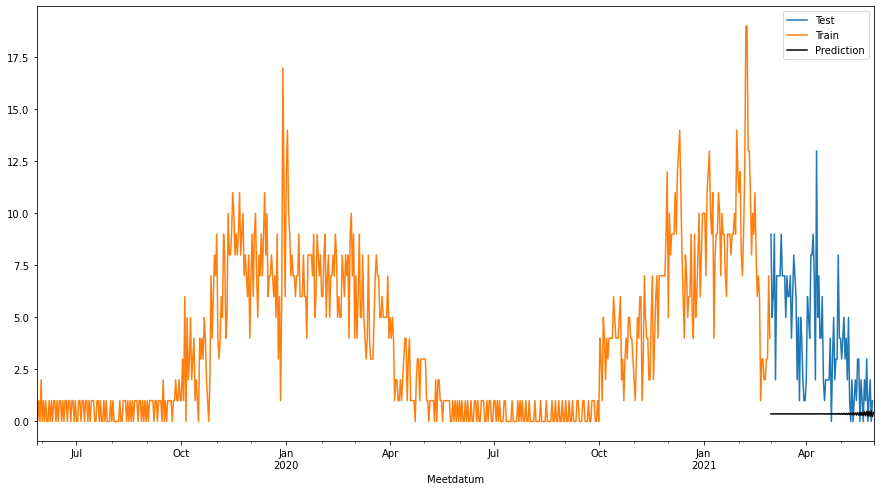

In [54]:
# Plot forecast
ax = ts_test['gas'].plot(label = 'Test')
ts_train['gas'].plot(label = 'Train', ax = ax)
#ax = ts['gas'].plot(colo = 'c')
ax.plot(ts_test.index, pred_gas_arima1, color = 'k', label = "Prediction")
#fit.forecast(24).rename('ARIMA').plot(ax=ax, style='--', color='C1',legend=True)
plt.legend()
plt.show()

#### Met fourier terms als seizoen

In [55]:
exog = pd.DataFrame({'date': ts.index}) # Initialieer 
exog = exog.set_index('date')

dict_aa = {}

for k in np.arange(2, 10, 2):
    
    # Maak fourier terms aan
    exog[f'sin365_{k}'] = np.sin(k * np.pi * exog.index.dayofyear / 365.25)
    exog[f'cos365_{k}'] = np.cos(k * np.pi * exog.index.dayofyear / 365.25)
    
    # Train test split
    exog_train = exog.iloc[-len(ts_train):]
    exog_test = exog.iloc[:len(ts_test)]
    
    # Auto arima doen
    res = pm.auto_arima(ts_train['sqrt'], 
                        d = 1,
                        start_p = 0, max_p = 2,
                        start_q = 1, max_q = 4,
                        exogenous = exog_train,
                        #seasonal = True, m = 365, D = 0,
                        #start_P = 1, max_P = 2,
                        #start_Q = 1, max_Q = 2,
                        information_criterion = 'aic', trace = True, 
                        error_action = 'ignore', stepwise = True
                       )
    # Beste model in dictionairy gooien
    dict_aa[k] = [res.order, res.aic()]
    
print()   
print(dict_aa)

Performing stepwise search to minimize aic
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=964.869, Time=0.82 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1325.967, Time=0.43 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1103.297, Time=0.74 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1323.970, Time=0.24 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=964.864, Time=1.45 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=965.044, Time=1.57 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=966.434, Time=2.52 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=965.128, Time=1.41 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1031.083, Time=0.67 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=964.514, Time=2.89 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=968.520, Time=3.03 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=3.90 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=962.587, Time=2.69 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=964.511, Time=1.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=963.1

In [56]:
# prepare Fourier terms
# k = 2 fourier terms geeft laagste AIC dus die maken we
exog = pd.DataFrame({'date': ts.index})
exog = exog.set_index(pd.PeriodIndex(exog['date'], freq='D'))
exog['sin365_2'] = np.sin(2 * np.pi * exog.index.dayofyear / 365.25)
exog['cos365_2'] = np.cos(2 * np.pi * exog.index.dayofyear / 365.25)
#exog['sin365_4'] = np.sin(4 * np.pi * exog.index.dayofyear / 365.25)
#exog['cos365_4'] = np.cos(4 * np.pi * exog.index.dayofyear / 365.25)
exog = exog.drop(columns=['date'])
exog.head()

sin365_2  cos365_2
date                          
2021-05-30  0.532227 -0.846602
2021-05-29  0.546711 -0.837321
2021-05-28  0.561034 -0.827793
2021-05-27  0.575190 -0.818020
2021-05-26  0.589176 -0.808005

In [57]:
# Transform index to period index
#ts_train.index = pd.DatetimeIndex(ts_train.index).to_period('d')

In [58]:
# Exogenous var train-test split
exog_train = exog.iloc[-len(ts_train):]
exog_test = exog.iloc[:len(ts_test)]
print(len(exog_train))
print(len(exog_test))

644
91


In [59]:
# Auto-ARIMA met X var
res_2 = pm.auto_arima(ts_train['sqrt'], 
                        d = 1,
                        start_p = 0, max_p = 2,
                        start_q = 2, max_q = 4,
                        exogenous = exog_train,
                        #seasonal = True, m = 365, D = 0,
                        #start_P = 1, max_P = 2,
                        #start_Q = 1, max_Q = 2,
                        information_criterion = 'aic', trace = True, 
                        error_action = 'ignore', stepwise = True
                       )
print(res_2.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=965.128, Time=1.37 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1325.967, Time=0.23 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1103.297, Time=0.71 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=964.869, Time=0.73 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1323.970, Time=0.29 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=964.864, Time=1.24 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=965.044, Time=1.75 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=966.434, Time=2.77 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1031.083, Time=0.81 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=964.514, Time=2.78 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=968.520, Time=3.35 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=2.56 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=962.587, Time=2.24 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=964.511, Time=1.28 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=963.1

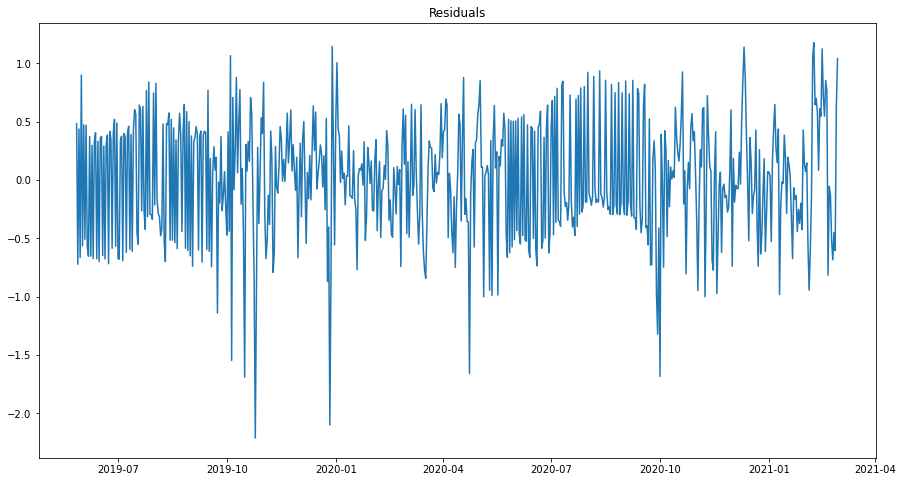

In [60]:
fig, ax = plt.subplots()
ax.plot(ts_train.index, res_2.resid())
#result_a_fourier.resid().plot()
plt.title('Residuals')
plt.show()

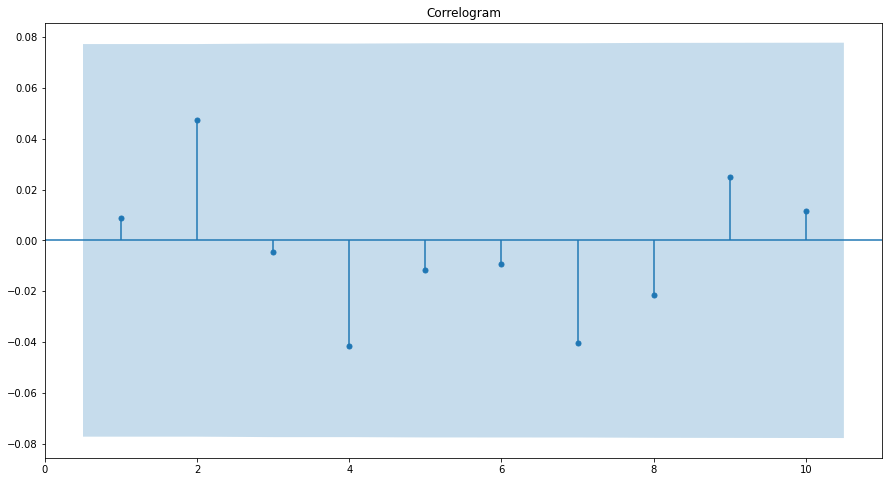

In [61]:
plot_acf(res_2.resid(), zero = False, lags = 10)
plt.title("Correlogram")
plt.show()

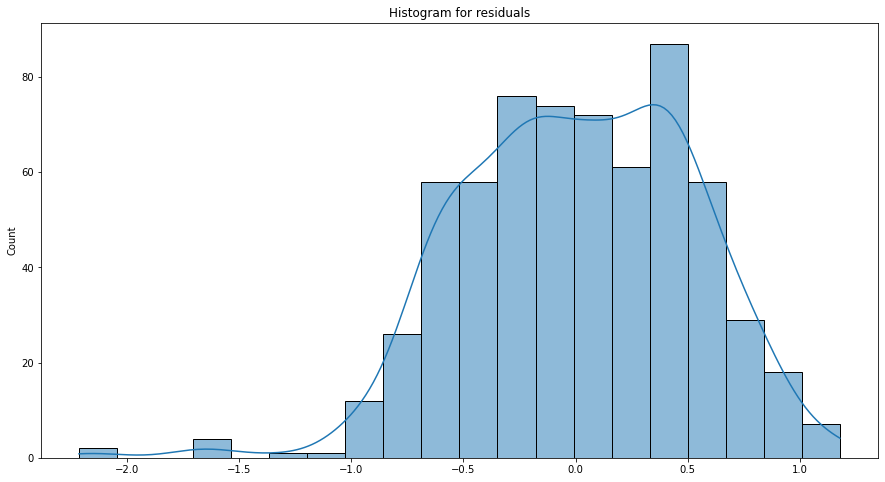

In [62]:
sns.histplot(res_2.resid(), kde = True, label = "Residuals")
plt.title('Histogram for residuals')
#plt.legend()
plt.show()

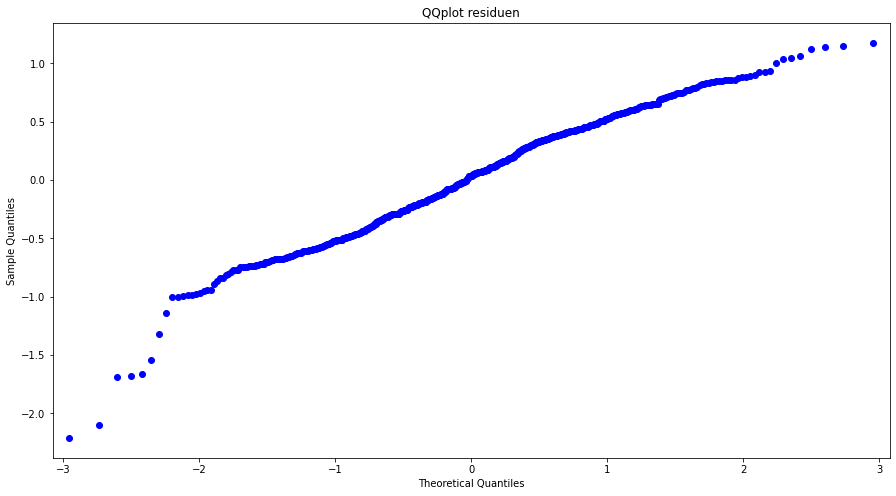

In [63]:
qqplot(res_2.resid())
plt.title('QQplot residuen')
plt.show()

#### Predictions

In [64]:
# In sample prediction
in_sample = res_2.predict_in_sample(exogenous=exog_train) ** 2
in_sample

date
2021-02-28    0.920478
2021-02-27    4.072024
2021-02-26    5.462458
2021-02-25    4.762314
2021-02-24    4.403682
                ...   
2019-05-31    0.264912
2019-05-30    0.441661
2019-05-29    0.316706
2019-05-28    0.521189
2019-05-27    0.266912
Freq: D, Name: predicted_mean, Length: 644, dtype: float64

In [65]:
# Out of sample prediction
#ts_test['pred_gas_arima2'] = (res_2.predict(len(ts_test), exogenous=exog_test) ** 2)
#ts_test.head(3)

In [66]:
#ax = ts_test['gas'].plot(label = 'Test') # Testset 
#ts_train['gas'].plot(label = 'Train', ax = ax) # Train set
#in_sample.plot(ax=ax, style='--', color='k', legend = False) # In sample pred
#ts_test['pred_gas_arima2'].plot(ax=ax, style='--', color = 'k',label = "Prediction") # Out of sample pred
#plt.legend()
#plt.show()

In [67]:
# prepare Fourier terms
# k = 2 fourier terms geeft laagste AIC dus die maken we

# Laatste datum die we gaan voorspellen
exog_max = ts_test.index.max() + datetime.timedelta(days = 365*5) # Is 5 jaar later
# Maak date index aan
exog = pd.DataFrame({'date': pd.date_range(start = ts_test.index.min(), end = exog_max)})
exog = exog.set_index(pd.PeriodIndex(exog['date'], freq='D'))
# Maak fourier terms aan
exog['sin365_2'] = np.sin(2 * np.pi * exog.index.dayofyear / 365.25)
exog['cos365_2'] = np.cos(2 * np.pi * exog.index.dayofyear / 365.25)
exog = exog.drop(columns=['date']) # Drop date kolom

# Make prediction
exog['pred'] = ((res_2.predict(len(exog), exogenous = exog)) ** 2)

exog.head()

C:\Users\Gebruiker\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


sin365_2  cos365_2      pred
date                                    
2021-03-01  0.858402  0.512978  7.025061
2021-03-02  0.867099  0.498137  6.048277
2021-03-03  0.875539  0.483147  7.024481
2021-03-04  0.883720  0.468015  5.902778
2021-03-05  0.891640  0.452745  6.759212

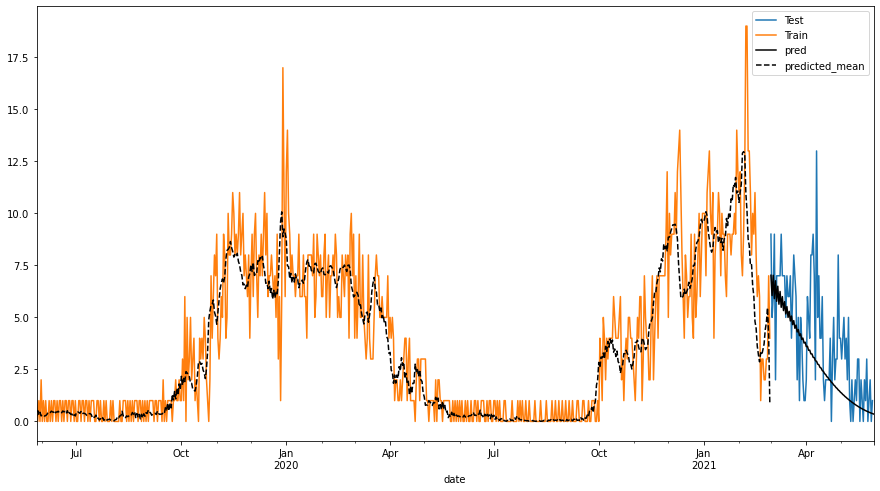

In [68]:
ax = ts_test['gas'].plot(label = 'Test') # Testset 
ts_train['gas'].plot(label = 'Train', ax = ax) # Train set
exog['pred'].plot(color = 'k') # Voorspelling
in_sample.plot(ax=ax, style='--', color='k', legend = False) # In sample pred
ax.set_xlim([ts_train.index.min(), ts_test.index.max()])
plt.legend()
plt.show()

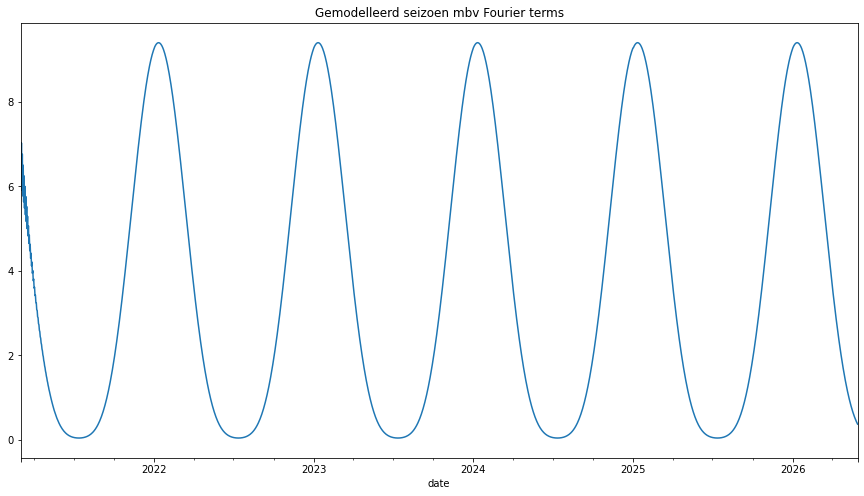

In [69]:
exog['pred'].plot()
plt.title('Gemodelleerd seizoen mbv Fourier terms')
plt.show()

In [70]:
# Merge prediction en testset
exog.index = exog.index.astype('datetime64[ns]') # Was eerst period maar om te mergen moet het dezelfde dtype zijn
true_vs_pred = ts_test[['gas']].merge(exog[['pred']], 
                                      left_index = True, right_index = True,
                                      how = 'left').dropna()
true_vs_pred.head(3)

gas      pred
Meetdatum                
2021-05-29  1.0  0.376643
2021-05-28  0.0  0.398792
2021-05-27  2.0  0.420009

In [71]:
# Bereken RMSE op test set
from sklearn.metrics import mean_squared_error

y_true_test = true_vs_pred['gas'].values
y_pred_test = true_vs_pred['pred'].values 
rmse = mean_squared_error(y_true_test, y_pred_test, squared = False)
print('RMSE test: %.3f' % rmse)

RMSE test: 2.443


## Dashboard
### Visualisaties

In [72]:
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff

#### Rolling mean lineplot

In [73]:
# Kolommen die geplot moeten worden
cols = ['gas', 'stroom', 'teruglevering']

In [74]:
# Rolling mean ts maken
ts_rolling = ts[cols].rolling(window = 7, center = True).mean()
ts_rolling.head()

gas    stroom  teruglevering
Meetdatum                                    
2021-05-30       NaN       NaN            NaN
2021-05-29       NaN       NaN            NaN
2021-05-28       NaN       NaN            NaN
2021-05-27       NaN       NaN            NaN
2021-05-26  1.142857  6.857143      13.428571

In [75]:
fig_rolling = go.Figure()

fig_rolling.add_trace(go.Scatter(
    x=ts_rolling.index,
    y=ts_rolling['gas'],
    name="Gas (m3)"
))

fig_rolling.add_trace(go.Scatter(
    x=ts_rolling.index,
    y=ts_rolling['stroom'],
    name="Stroom (kWh)"
))

fig_rolling.add_trace(go.Scatter(
    x=ts_rolling.index,
    y=ts_rolling['teruglevering'],
    name="Stroomteruglevering (kWh)"
))

fig_rolling.update_layout(legend=dict(orientation="h",
                                      yanchor="bottom",
                                      y=1.02,
                                      xanchor="right",
                                      x=1),
                         title={
                             'text': "Verbruik",
                             'y':0.86,
                             'x': 0.08},
                          yaxis_title="Waarde",
                          xaxis_title="Datum",
                         #margin={"r":0,"t":0,"l":0,"b":0},
                         template="ggplot2")

fig_rolling.show()

#### Gemiddeld verbruik per maand lineplot
Om het seizoen te visualiseren

In [76]:
# Gemiddelden per maand krijgen
ts_grouped = ts.groupby('month')[cols].mean()
ts_grouped.head()

gas     stroom  teruglevering
month                                    
1      8.483871  11.693548       1.709677
2      7.561404   9.912281       5.107143
3      5.451613  10.354839       8.193548
4      3.400000  10.366667      14.200000
5      1.369231  10.169231      13.034483

In [77]:
fig_grouped = go.Figure()
# Plotten
fig_grouped.add_trace(go.Scatter(
    x=ts_grouped.index,
    y=ts_grouped['gas'],
    name="Gas (m3)"
))

fig_grouped.add_trace(go.Scatter(
    x=ts_grouped.index,
    y=ts_grouped['stroom'],
    name="Stroom (kWh)"
))

fig_grouped.add_trace(go.Scatter(
    x=ts_grouped.index,
    y=ts_grouped['teruglevering'],
    name="Stroomteruglevering (kWh)"
))
# Labels en plaatsing labels
fig_grouped.update_layout(legend=dict(orientation="h",
                                      yanchor="bottom",
                                      y=1.02,
                                      xanchor="right",
                                      x=1),
                         title={
                             'text': "Gemiddeld verbruik per maand",
                             'y':0.86,
                             'x': 0.08},
                          #margin={"r":0,"t":0,"l":0,"b":0},
                          template="ggplot2",
                          yaxis_title="Waarde",
                          xaxis = dict(tickmode = 'array',
                                       tickvals = [*range(1, 13)],
                                       ticktext = ['Jan', 'Feb', 'Maart', 'April', 'Mei', 'Juni', 'Juli',
                                                   'Aug','Sept', 'Okt', 'Nov', "Dec"]
    )
)

fig_grouped.show()

#### Boxplots per maand per verbruik
Vanaf nu gaat alles over gas

In [78]:
fig_boxplot = go.Figure()

fig_boxplot.add_trace(go.Box(x=ts["month"], y=ts["gas"],
    #name="Whiskers and Outliers",
    #boxpoints='outliers', # only outliers
    marker_color='rgb(199, 124, 255)',
    line_color='rgb(248,118,109)'
))

# Labels en plaatsing labels
fig_boxplot.update_layout(title={
                             'text': "Boxplots voor gasverbruik per maand",
                             'y':0.88,
                             'x': 0.06},
                          margin={"r":0,"l":0,"b":0},
                          yaxis_title="Gas (m3)",
                          template="ggplot2",
                          width = 800, height = 600,
                          xaxis = dict(tickmode = 'array',
                                       tickvals = [*range(1, 13)],
                                       ticktext = ['Jan', 'Feb', 'Maart', 'April', 'Mei', 'Juni', 'Juli',
                                                   'Aug','Sept', 'Okt', 'Nov', "Dec"]
    )
)

fig_boxplot.show()

#### Gedifferentieerd gas + wortel gas lineplot

In [79]:
ts_diff.head(3)

gas      sqrt
Meetdatum                
2021-05-28 -1.0 -1.000000
2021-05-27  2.0  1.414214
2021-05-26 -1.0 -0.414214

In [80]:
fig_diff = go.Figure()
# Plotten
fig_diff.add_trace(go.Scatter(
    x=ts_diff.index,
    y=ts_diff['gas'],
    name="Gas (m3)",
    line_color='rgb(168,202,84)'
))

fig_diff.add_trace(go.Scatter(
    x=ts_diff.index,
    y=ts_diff['sqrt'],
    name="Wortel gas (m3)",
    line_color='rgb(0,191,196)'
))

# Labels en plaatsing labels
fig_diff.update_layout(legend=dict(orientation="h", # Legenda plek etc
                                      yanchor="bottom",
                                      y=1.01,
                                      xanchor="right",
                                      x=1
                                  ),
                       width = 800, height = 600, # Grootte
                       title={'text': "Gedifferentieerd gasverbruik", #Titel plek etc
                              'y': 0.87,
                              'x': 0.05},
                       margin={"r":0,"l":0,"b":0},
                       template="ggplot2",
                       xaxis_title="Datum" #xlabel
)

fig_diff.show()

#### ARIMA
##### Voorspelling

In [81]:
# Moet datetime zijn om te plotten in plotly
in_sample.index = in_sample.index.astype('datetime64[ns]')

In [82]:
fig_pred = go.Figure()#title = 'Resultaat van het ARIMA model') # Initialiseer figuur

# Voeg trainset toe
fig_pred.add_trace(go.Scatter(name = "Train", mode = "lines", 
                              x = ts_train.index,
                              y = ts_train['gas'],
                              line_color='rgb(97,196,255)'
                              #xperiodalignment="start"
                             ))

# Voeg testset toe
fig_pred.add_trace(go.Scatter(name = "Test", mode = "lines", 
                              x = ts_test.index,
                              y = ts_test['gas'],
                              line_color='rgb(212,134,182)'
                              #xperiodalignment="start"
                             ))

# Voeg insample pred toe
fig_pred.add_trace(go.Scatter(name = "Voorspelling voor trainset", mode = "lines", 
                              x = in_sample.index,
                              y = in_sample.values,
                              line_color='rgb(49,133,182)'
                              #xperiodalignment="start"
                             ))

# Voeg pred voor testset toe
fig_pred.add_trace(go.Scatter(name = "Voorspelling voor testset", mode = "lines", 
                              x = exog.index,
                              y = exog['pred'],
                              line_color='rgb(160,77,128)'
                              #xperiodalignment="start"
                             ))

fig_pred.update_xaxes(showgrid=True, range=[ts_train.index.min(), ts_test.index.max()])#, ticklabelmode="period")

# Labels en plaatsing labels
fig_pred.update_layout(legend=dict(orientation="h",
                                      yanchor="bottom",
                                      y=1.02,
                                      xanchor="right",
                                      x=1),
                       title={'text': "Resultaat ARIMA",
                              'y': 0.86,
                              'x': 0.08},
                       #margin={"r":0,"t":0,"l":0,"b":0},
                       xaxis_title="Datum",
                       template="ggplot2"
)

fig_pred.show()
# Zet al die setting nog uit

In [83]:
fig_season = go.Figure()

fig_season.add_trace(go.Scatter(x = exog.index, 
                         y = exog['pred'],
                         line_color="rgb(124,174,0)")
              
             )

# Labels en plaatsing labels
fig_season.update_layout(
                       title={'text': "Gemodelleerd seizoen door ARIMA",
                              'y': 0.86,
                              'x': 0.08},
                       #margin={"r":0,"t":0,"l":0,"b":0},
                       xaxis_title="Datum",
                       template="ggplot2"
)

fig_season.show()

##### Residuen

In [84]:
fig_res_line = px.line(x = ts_train.index, y = res_2.resid(), template="ggplot2")

# Labels en plaatsing labels
fig_res_line.update_layout(title={'text': "Residu",
                                  'y': 0.97,
                                  'x': 0.08},
                           template="ggplot2",
                           xaxis_title="Datum",
                           yaxis_title="Waarde",
                           margin={"r":0,"t":40,"l":0,"b":0}
)

fig_res_line.show()

##### ACF residuen

##### Verdeling residu

In [85]:
fig_res_hist = ff.create_distplot([res_2.resid()], 
                                  group_labels = ["Residu"],
                                  bin_size = .2,
                                  show_rug=False, colors = ['rgb(0,191,196)']
                        )

# Labels en plaatsing labels
fig_res_hist.update_layout(title={'text': "Verdeling van residu",
                                  'y': 0.97,
                                  'x': 0.03},
                           template="ggplot2",
                           xaxis_title="Waarde",
                           margin={"r":0,'t':40,"l":0,"b":0},
                           showlegend=False
)

fig_res_hist.show()

##### QQplot residu

In [86]:
from scipy import stats

In [87]:
# Theoretische quantielen genereren
X_norm = np.random.normal(loc=0.0, scale=1, size=len(res_2.resid()))

qq = stats.probplot(X_norm, dist='norm', sparams=(1))
x = np.array([qq[0][0][0], qq[0][0][-1]])

In [88]:
# QQplot maken
fig_qq = go.Figure()
fig_qq.add_scatter(name = 'QQ',
                   x=qq[0][0], y=res_2.resid().sort_values(), 
                   mode='markers',
                   line_color='rgb(0,191,196)')
fig_qq.add_scatter(name = 'Referentie lijn',
                   x=x, y=x, 
                   mode='lines',
                   line_color='rgb(248,118,109)')


# Labels en plaatsing labels
fig_qq.update_layout(title={'text': "QQ-plot residu",
                                  'y': 0.98,
                                  'x': 0.08},
                     legend=dict(orientation="h",
                                      yanchor="bottom",
                                      y=1.02,
                                      xanchor="right",
                                      x=1),
                     template="ggplot2",
                     margin={"r":0,"t":0,"l":40,"b":0},
                           xaxis_title="Theoretische kwantielen",
                           yaxis_title="Werkelijke kwantielen"
)

fig_qq.show()

### Dashboard maken

In [89]:
import dash
import dash_core_components as dcc
import dash_html_components as html

In [90]:
# see https://plotly.com/python/px-arguments/ for more options
df = pd.DataFrame({
    "Fruit": ["Apples", "Oranges", "Bananas", "Apples", "Oranges", "Bananas"],
    "Amount": [4, 1, 2, 2, 4, 5],
    "City": ["SF", "SF", "SF", "Montreal", "Montreal", "Montreal"]
})

fig = px.bar(df, x="Fruit", y="Amount", color="City", barmode="group")


In [ ]:
# Run this app with `python app.py` and
# visit http://127.0.0.1:8050/ in your web browser.

external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']

app = dash.Dash(__name__, external_stylesheets=external_stylesheets)

app.layout = html.Div(children=[
    
    # Titel
    html.H1(children='Energieverbruik',
            style={'font-weight': 'bold', 'text-align':'center'}
           ),
    
    # Verbruik alles
    dcc.Graph(
        figure=fig_rolling,
        style={"display": "block",
               "margin-left": "auto",
               "margin-right": "auto"}
    ),
    
    # Gemiddelde per maand alles
    dcc.Graph(
        figure=fig_grouped
    ),
    
    # Tekst voor vanaf nu alleen gas
    html.Div([html.H3(children='Gasverbruik', 
                      style={'text-align':'center'})]),
    # Boxplot en gedifferentieerd verbruik gas
    html.Div([dcc.Graph(figure=fig_boxplot, style={'width': 'auto', 
                                                   'height':'auto', 
                                                   'display': 'inline-block',
                                                   "margin-left": 150,
                                                   "margin-right": "auto"}), 
              dcc.Graph(figure=fig_diff, style={'width': 'auto', 
                                                'height':'auto', 
                                                'display': 'inline-block',
                                                "margin-left": "auto",
                                                "margin-right": "auto"})]),
    
    # ARIMA tekst
    html.Div([html.H3(children='ARIMA model met twee Fourier terms', 
                      style={'text-align':'center'})]),
    # ARIMA resultaat
    dcc.Graph(
        figure=fig_pred
    ), 
    
    # Seizoen 
    dcc.Graph(
        figure=fig_season
    ),

    # Tekst voor vanaf nu alleen gas
    html.Div([html.H3(children='Model verifiëren', 
                      style={'text-align':'center'})]),
    # Model verifiëren
    html.Div([dcc.Graph(figure=fig_res_line, style={'width': 'auto', 'height':'auto', 
                                                    'display': 'inline-block',
                                                    "margin-left": 200}), 
              dcc.Graph(figure=fig_res_hist, style={'width': 'auto', 'height':'auto', 
                                                    'display': 'inline-block',
                                                    "margin-left": 20}),
              dcc.Graph(figure=fig_qq, style={'width': 'auto', 'height':'auto', 
                                              'display': 'inline-block',
                                              "margin-left":550})]),
    #dcc.Graph(
    #    figure=fig_qq
    #),
])

if __name__ == '__main__':
    app.run_server(debug=False)

Dash is running on http://127.0.0.1:8050/

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:8050/ (Press CTRL+C to quit)
